#**MNIST cu ANN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torch.nn.functional as F          
from torch.utils.data import DataLoader  
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  
import matplotlib.pyplot as plt
from IPython import display as dspl

import time
import torchvision

In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

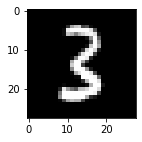

clasa imaginii =  3


In [ ]:
n = 10000

for idx, (img, cls) in enumerate(train_data):
  if idx % n == 0:
    dspl.clear_output(wait=True)
  
    plt.figure(figsize = (2, 2))
    plt.imshow(np.squeeze(np.transpose(img.numpy()[:2], (1, 2, 0))), cmap="gray")
    plt.show()
    print("clasa imaginii = ", cls)
    
    time.sleep(2)

In [ ]:
batch_size_train = 500
batch_size_test = 100

train_loader = data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True, num_workers=2)
test_loader = data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False)



Labels:  [   3    7    6    0    1    5    7    5    6    3    8    6]


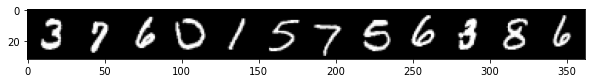

In [ ]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) 

for images,labels in train_loader: 
    break

print('Labels: ', labels[:12].numpy())

im = make_grid(images[:12], nrow=12)  
plt.figure(figsize=(10,4))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Retea cu un strat ascuns

In [ ]:
class OneHidden(nn.Module):

  def __init__(self):
    super(OneHidden, self).__init__()
    self.fc1 = nn.Linear(784, 300)
    self.fc2 = nn.Linear(300, 10)

  def forward(self, x: torch.Tensor):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return F.log_softmax(x, dim=1)
    

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
model = OneHidden()
count_parameters(model)

235200
   300
  3000
    10
______
238510


In [ ]:
def train_fn(epochs: int, train_loader: data.DataLoader, test_loader: data.DataLoader, 
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer):

  for e in range(epochs):
    total = 0
    train_corr = 0
   
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      out = net(images.view(batch_size_train, -1))

      loss = loss_fn(out, labels)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      total += len(images)
      predicted = torch.max(out.data, 1)[1]
      nr_corr_batch = (predicted == labels).sum()
      train_corr += nr_corr_batch
    
    acc_train = (train_corr / total) * 100
    
    train_accs.append((e, acc_train))
    train_losses.append((e, loss.item()))

    total = 0
    test_corr = 0 

    with torch.no_grad():
      for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        total += len(test_images)
        y_val = net(test_images.view(batch_size_test, -1))
        out_class = torch.max(y_val.data, 1)[1]
        test_corr += (out_class == test_labels).sum()

    loss_test = loss_fn(y_val, test_labels)
    acc_test = (test_corr / total) * 100
    test_accs.append((e, acc_test))
    test_losses.append((e, loss_test.item()))

    print(f'epoch: {e:2}  loss_train/test: {loss.item():10.8f}/{loss_test.item():10.8f}  accuracy_train/test: {acc_train:7.3f}% / {acc_test:7.3f}%')
    

In [ ]:
class OneHidden(nn.Module):

  def __init__(self):
    super(OneHidden, self).__init__()
    self.fc1 = nn.Linear(784, 300)
    self.fc2 = nn.Linear(300, 10)

  def forward(self, x: torch.Tensor):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return x
    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
epochs = 50

model = OneHidden() # fara softmax
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-2)

optimizer.zero_grad()

loss_fn = nn.CrossEntropyLoss()

train_accs = []
test_accs = []
train_losses = []
test_losses = []

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer)

epoch:  0  loss_train/test: 2.13164544/2.13354945  accuracy_train/test:  37.362% /  57.650%
epoch:  1  loss_train/test: 1.88064551/1.89015627  accuracy_train/test:  60.670% /  63.700%
epoch:  2  loss_train/test: 1.56815922/1.61828184  accuracy_train/test:  64.613% /  67.620%
epoch:  3  loss_train/test: 1.38532519/1.40486431  accuracy_train/test:  68.220% /  71.050%
epoch:  4  loss_train/test: 1.04905820/1.12964666  accuracy_train/test:  72.325% /  79.940%
epoch:  5  loss_train/test: 0.75628853/0.94282454  accuracy_train/test:  81.920% /  83.870%
epoch:  6  loss_train/test: 0.69521719/0.83761209  accuracy_train/test:  84.005% /  85.190%
epoch:  7  loss_train/test: 0.62747663/0.77249885  accuracy_train/test:  85.030% /  86.200%
epoch:  8  loss_train/test: 0.59699434/0.72697318  accuracy_train/test:  85.877% /  87.060%
epoch:  9  loss_train/test: 0.51724046/0.69201058  accuracy_train/test:  86.492% /  87.510%
epoch: 10  loss_train/test: 0.51319635/0.66508049  accuracy_train/test:  86.978%

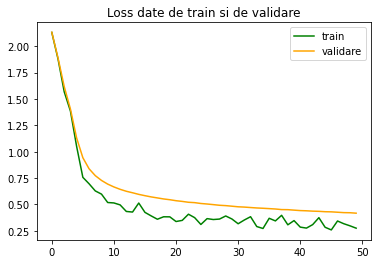

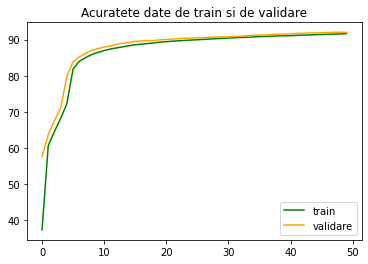

In [ ]:
import matplotlib.pyplot as plt
plt.figure()

x_val_train_loss = [x[0] for x in train_losses]
y_val_train_loss = [x[1] for x in train_losses]
plt.plot(x_val_train_loss, y_val_train_loss, color = 'green', label = 'train')
x_val_valid_loss = [x[0] for x in test_losses]
y_val_valid_loss = [x[1] for x in test_losses]
plt.plot(x_val_valid_loss, y_val_valid_loss, color = 'orange', label = 'validare')
plt.title("Loss date de train si de validare")
plt.legend()
plt.figure()

x_val_train_acc = [x[0] for x in train_accs]
y_val_train_acc = [torch.Tensor.cpu(x[1]) for x in train_accs]
plt.plot(x_val_train_acc, y_val_train_acc, color = 'green', label = 'train')
from torch import Tensor
x_val_valid_acc = [x[0] for x in test_accs]
y_val_valid_acc = [torch.Tensor.cpu(x[1]) for x in test_accs]
plt.plot(x_val_valid_acc, y_val_valid_acc, color = 'orange', label = 'validare')
plt.title("Acuratete date de train si de validare")
plt.legend()



In [ ]:
class OneHidden(nn.Module):

  def __init__(self):
    super(OneHidden, self).__init__()
    self.fc1 = nn.Linear(784, 300)
    self.fc2 = nn.Linear(300, 10)

  def forward(self, x: torch.Tensor):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return F.log_softmax(x, dim=1)
    

In [ ]:
epochs = 50

model = OneHidden() # cu softmax
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer.zero_grad()

loss_fn = nn.CrossEntropyLoss()

train_accs = []
test_accs = []
train_losses = []
test_losses = []

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer)

epoch:  0  loss_train/test: 0.26133406/0.38075119  accuracy_train/test:  85.742% /  92.260%
epoch:  1  loss_train/test: 0.20671931/0.31203806  accuracy_train/test:  93.233% /  94.370%
epoch:  2  loss_train/test: 0.18022776/0.22993331  accuracy_train/test:  94.978% /  95.350%
epoch:  3  loss_train/test: 0.13080817/0.15849216  accuracy_train/test:  95.992% /  96.180%
epoch:  4  loss_train/test: 0.15562113/0.14753036  accuracy_train/test:  96.750% /  96.560%
epoch:  5  loss_train/test: 0.12568183/0.10960398  accuracy_train/test:  97.277% /  97.000%
epoch:  6  loss_train/test: 0.06499281/0.09475099  accuracy_train/test:  97.668% /  97.010%
epoch:  7  loss_train/test: 0.13886563/0.08273545  accuracy_train/test:  97.945% /  97.320%
epoch:  8  loss_train/test: 0.06877601/0.06378320  accuracy_train/test:  98.275% /  97.460%
epoch:  9  loss_train/test: 0.05999205/0.05871149  accuracy_train/test:  98.528% /  97.670%
epoch: 10  loss_train/test: 0.03052798/0.06179620  accuracy_train/test:  98.677%

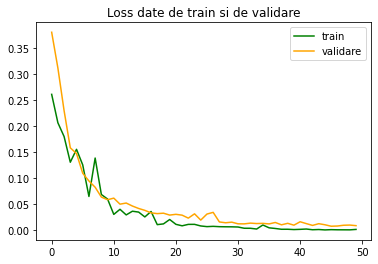

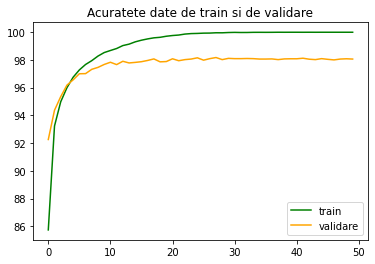

In [ ]:
# one hidden, cu softmax, adam 
import matplotlib.pyplot as plt
plt.figure()

x_val_train_loss = [x[0] for x in train_losses]
y_val_train_loss = [x[1] for x in train_losses]
plt.plot(x_val_train_loss, y_val_train_loss, color = 'green', label = 'train')
x_val_valid_loss = [x[0] for x in test_losses]
y_val_valid_loss = [x[1] for x in test_losses]
plt.plot(x_val_valid_loss, y_val_valid_loss, color = 'orange', label = 'validare')
plt.title("Loss date de train si de validare")
plt.legend()
plt.figure()

x_val_train_acc = [x[0] for x in train_accs]
y_val_train_acc = [torch.Tensor.cpu(x[1]) for x in train_accs]
plt.plot(x_val_train_acc, y_val_train_acc, color = 'green', label = 'train')
from torch import Tensor
x_val_valid_acc = [x[0] for x in test_accs]
y_val_valid_acc = [torch.Tensor.cpu(x[1]) for x in test_accs]
plt.plot(x_val_valid_acc, y_val_valid_acc, color = 'orange', label = 'validare')
plt.title("Acuratete date de train si de validare")
plt.legend()



In [ ]:
epochs = 50

model = OneHidden() # fara softmax
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer.zero_grad()

loss_fn = nn.CrossEntropyLoss()

train_accs = []
test_accs = []
train_losses = []
test_losses = []

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer)

epoch:  0  loss_train/test: 0.52979898/0.68165869  accuracy_train/test:  81.823% /  90.410%
epoch:  1  loss_train/test: 0.43802884/0.56073153  accuracy_train/test:  91.635% /  93.070%
epoch:  2  loss_train/test: 0.36249074/0.49751005  accuracy_train/test:  93.947% /  94.510%
epoch:  3  loss_train/test: 0.38637078/0.44142658  accuracy_train/test:  95.092% /  95.320%
epoch:  4  loss_train/test: 0.28827220/0.41930920  accuracy_train/test:  95.973% /  96.070%
epoch:  5  loss_train/test: 0.34758839/0.42102838  accuracy_train/test:  96.575% /  95.920%
epoch:  6  loss_train/test: 0.30011427/0.37541735  accuracy_train/test:  96.968% /  96.710%
epoch:  7  loss_train/test: 0.23483029/0.37376577  accuracy_train/test:  97.390% /  96.820%
epoch:  8  loss_train/test: 0.28925014/0.34169903  accuracy_train/test:  97.647% /  97.050%
epoch:  9  loss_train/test: 0.28802708/0.33764690  accuracy_train/test:  97.967% /  97.130%
epoch: 10  loss_train/test: 0.24093992/0.33487880  accuracy_train/test:  98.135%

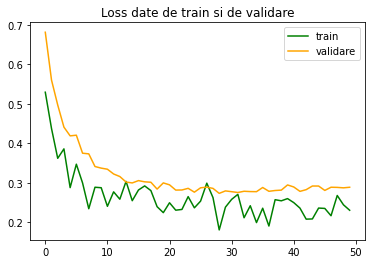

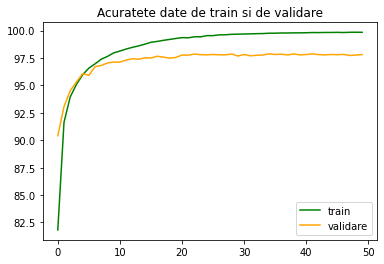

In [ ]:
# one hidden, fara softmax, adam 
import matplotlib.pyplot as plt
plt.figure()

x_val_train_loss = [x[0] for x in train_losses]
y_val_train_loss = [x[1] for x in train_losses]
plt.plot(x_val_train_loss, y_val_train_loss, color = 'green', label = 'train')
x_val_valid_loss = [x[0] for x in test_losses]
y_val_valid_loss = [x[1] for x in test_losses]
plt.plot(x_val_valid_loss, y_val_valid_loss, color = 'orange', label = 'validare')
plt.title("Loss date de train si de validare")
plt.legend()
plt.figure()

x_val_train_acc = [x[0] for x in train_accs]
y_val_train_acc = [torch.Tensor.cpu(x[1]) for x in train_accs]
plt.plot(x_val_train_acc, y_val_train_acc, color = 'green', label = 'train')
from torch import Tensor
x_val_valid_acc = [x[0] for x in test_accs]
y_val_valid_acc = [torch.Tensor.cpu(x[1]) for x in test_accs]
plt.plot(x_val_valid_acc, y_val_valid_acc, color = 'orange', label = 'validare')
plt.title("Acuratete date de train si de validare")
plt.legend()



## Retea cu doua straturi ascunse

In [ ]:
class TwoHidden(nn.Module):

  def __init__(self):
    super(TwoHidden, self).__init__()
    self.fc1 = nn.Linear(784, 300)
    self.fc2 = nn.Linear(300, 100)
    self.fc3 = nn.Linear(100, 10)

  def forward(self, x: torch.Tensor):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim=1)
    

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
model = TwoHidden()
count_parameters(model)

235200
   300
 30000
   100
  1000
    10
______
266610


In [ ]:
train_accs = []
test_accs = []
train_losses = []
test_losses = []
epochs = 50

model = TwoHidden() # cu softmax
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer.zero_grad()

loss_fn = nn.CrossEntropyLoss()

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer)

epoch:  0  loss_train/test: 0.23308714/0.38936630  accuracy_train/test:  85.605% /  92.460%
epoch:  1  loss_train/test: 0.18605050/0.24877945  accuracy_train/test:  93.715% /  94.870%
epoch:  2  loss_train/test: 0.13519165/0.18714932  accuracy_train/test:  95.500% /  96.010%
epoch:  3  loss_train/test: 0.05516138/0.17250815  accuracy_train/test:  96.543% /  96.440%
epoch:  4  loss_train/test: 0.11378232/0.09905932  accuracy_train/test:  97.227% /  97.080%
epoch:  5  loss_train/test: 0.07029065/0.09310374  accuracy_train/test:  97.778% /  97.370%
epoch:  6  loss_train/test: 0.04343782/0.10735291  accuracy_train/test:  98.152% /  97.650%
epoch:  7  loss_train/test: 0.06758436/0.07084340  accuracy_train/test:  98.500% /  97.880%
epoch:  8  loss_train/test: 0.03398499/0.07012741  accuracy_train/test:  98.758% /  97.750%
epoch:  9  loss_train/test: 0.05932660/0.07462563  accuracy_train/test:  98.953% /  97.810%
epoch: 10  loss_train/test: 0.05892069/0.05759655  accuracy_train/test:  99.105%

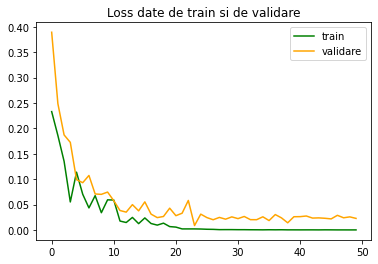

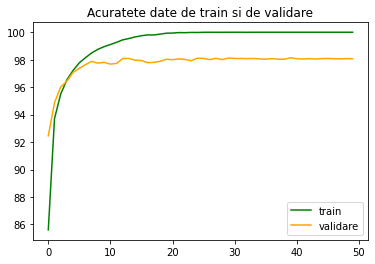

In [ ]:
# two hidden, cu softmax, adam 
import matplotlib.pyplot as plt
plt.figure()

x_val_train_loss = [x[0] for x in train_losses]
y_val_train_loss = [x[1] for x in train_losses]
plt.plot(x_val_train_loss, y_val_train_loss, color = 'green', label = 'train')
x_val_valid_loss = [x[0] for x in test_losses]
y_val_valid_loss = [x[1] for x in test_losses]
plt.plot(x_val_valid_loss, y_val_valid_loss, color = 'orange', label = 'validare')
plt.title("Loss date de train si de validare")
plt.legend()
plt.figure()

x_val_train_acc = [x[0] for x in train_accs]
y_val_train_acc = [torch.Tensor.cpu(x[1]) for x in train_accs]
plt.plot(x_val_train_acc, y_val_train_acc, color = 'green', label = 'train')
from torch import Tensor
x_val_valid_acc = [x[0] for x in test_accs]
y_val_valid_acc = [torch.Tensor.cpu(x[1]) for x in test_accs]
plt.plot(x_val_valid_acc, y_val_valid_acc, color = 'orange', label = 'validare')
plt.title("Acuratete date de train si de validare")
plt.legend()



In [ ]:
class TwoHidden(nn.Module):

  def __init__(self):
    super(TwoHidden, self).__init__()
    self.fc1 = nn.Linear(784, 300)
    self.fc2 = nn.Linear(300, 100)
    self.fc3 = nn.Linear(100, 10)

  def forward(self, x: torch.Tensor):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x
    

In [ ]:
train_accs = []
test_accs = [] 
train_losses = []
test_losses = []
epochs = 50

model = TwoHidden() # fara softmax
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

optimizer.zero_grad()

loss_fn = nn.CrossEntropyLoss()

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer)

epoch:  0  loss_train/test: 0.25918636/0.41727757  accuracy_train/test:  85.070% /  92.280%
epoch:  1  loss_train/test: 0.17678873/0.25868452  accuracy_train/test:  93.490% /  94.540%
epoch:  2  loss_train/test: 0.12426077/0.20308577  accuracy_train/test:  95.240% /  95.450%
epoch:  3  loss_train/test: 0.16503923/0.17448616  accuracy_train/test:  96.343% /  96.290%
epoch:  4  loss_train/test: 0.10007123/0.08043320  accuracy_train/test:  97.007% /  96.760%
epoch:  5  loss_train/test: 0.08228873/0.06392986  accuracy_train/test:  97.613% /  97.280%
epoch:  6  loss_train/test: 0.05533100/0.08337195  accuracy_train/test:  97.952% /  97.370%
epoch:  7  loss_train/test: 0.04068645/0.06401893  accuracy_train/test:  98.400% /  97.610%
epoch:  8  loss_train/test: 0.05198032/0.04942213  accuracy_train/test:  98.607% /  97.650%
epoch:  9  loss_train/test: 0.05935313/0.03262271  accuracy_train/test:  98.882% /  97.680%
epoch: 10  loss_train/test: 0.05340580/0.03941579  accuracy_train/test:  99.033%

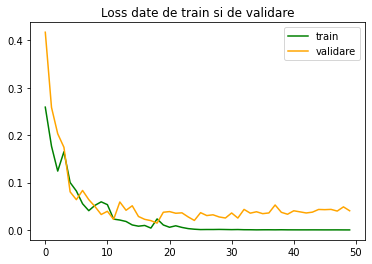

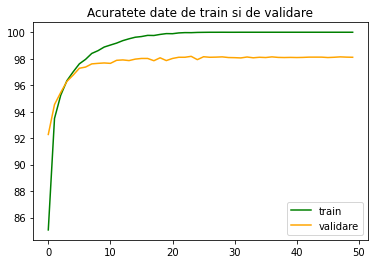

In [ ]:
# two hidden, fara softmax, adam
import matplotlib.pyplot as plt
plt.figure()

x_val_train_loss = [x[0] for x in train_losses]
y_val_train_loss = [x[1] for x in train_losses]
plt.plot(x_val_train_loss, y_val_train_loss, color = 'green', label = 'train')
x_val_valid_loss = [x[0] for x in test_losses]
y_val_valid_loss = [x[1] for x in test_losses]
plt.plot(x_val_valid_loss, y_val_valid_loss, color = 'orange', label = 'validare')
plt.title("Loss date de train si de validare")
plt.legend()
plt.figure()

x_val_train_acc = [x[0] for x in train_accs]
y_val_train_acc = [torch.Tensor.cpu(x[1]) for x in train_accs]
plt.plot(x_val_train_acc, y_val_train_acc, color = 'green', label = 'train')
from torch import Tensor
x_val_valid_acc = [x[0] for x in test_accs]
y_val_valid_acc = [torch.Tensor.cpu(x[1]) for x in test_accs]
plt.plot(x_val_valid_acc, y_val_valid_acc, color = 'orange', label = 'validare')
plt.title("Acuratete date de train si de validare")
plt.legend()



In [ ]:
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []
epochs = 50

model = TwoHidden() # fara softmax
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-2)

optimizer.zero_grad()

loss_fn = nn.CrossEntropyLoss()

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer)

epoch:  0  loss_train/test: 2.26885986/2.26500535  accuracy_train/test:  15.683% /  26.480%
epoch:  1  loss_train/test: 2.21234894/2.20994091  accuracy_train/test:  34.252% /  43.000%
epoch:  2  loss_train/test: 2.09566879/2.10934806  accuracy_train/test:  50.345% /  57.610%
epoch:  3  loss_train/test: 1.92443752/1.93347776  accuracy_train/test:  60.902% /  65.010%
epoch:  4  loss_train/test: 1.64233172/1.65530324  accuracy_train/test:  67.327% /  70.640%
epoch:  5  loss_train/test: 1.27164781/1.32498002  accuracy_train/test:  73.323% /  76.650%
epoch:  6  loss_train/test: 0.94668317/1.06828403  accuracy_train/test:  78.628% /  80.740%
epoch:  7  loss_train/test: 0.77664906/0.91178644  accuracy_train/test:  81.173% /  82.610%
epoch:  8  loss_train/test: 0.72541285/0.81303489  accuracy_train/test:  82.728% /  84.040%
epoch:  9  loss_train/test: 0.58577514/0.74403566  accuracy_train/test:  84.088% /  85.290%
epoch: 10  loss_train/test: 0.58074373/0.69554406  accuracy_train/test:  85.125%